<a href="https://colab.research.google.com/github/oikn2018/CS6910_assignment_2/blob/main/a2_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=99c89e280243504156ce6062115d3a2681c6d871c1f6781f8696ab4205e4cf19
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import random
import wget
import os
import datetime
from zipfile import ZipFile
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models
import copy
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
# dir(models)

In [4]:
url='https://storage.googleapis.com/wandb_datasets/nature_12K.zip'
filename = os.path.basename(url)

if not os.path.exists(filename) and not os.path.exists("inaturalist_12K"):
  filename = wget.download(url)
  with ZipFile(filename, 'r') as z:
    print('Extracting files...')
    z.extractall()
    print('Done!')
  os.remove(filename)

Extracting files...
Done!


In [5]:
classes = sorted([name for name in os.listdir("inaturalist_12K/train") if name != '.DS_Store'])
print(classes)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [6]:
image_size = (256,256)
num_layers = 5
num_classes = len(classes)

In [7]:
#default config
config = {
    "size_filters" : [7,5,5,3,3],
    "activation" : 'ReLU',
    "learning_rate": 1e-3,
    "filters_org": 1,
    "num_filters" : 64,
    "dense_layer_size" : 256,
    "batch_norm": False,
    "data_augment": False,
    "dropout":0,
    "batch_size":32,
    "epochs": 10
    }

In [8]:
list_filters = []
for i in range(5):
  if config['filters_org'] == 1:
    list_filters.append(config['num_filters'])
  elif config['filters_org'] == 0.5:
    list_filters.append(int(config['num_filters']/(2**i)))
  else:
    list_filters.append(int(config['num_filters']*(2**i)))

print(list_filters)

[64, 64, 64, 64, 64]


In [9]:
batch_size = config['batch_size']
# trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform.ToTensor())

if config["data_augment"]:
    transform_train = transforms.Compose([
        transforms.RandomRotation(degrees=50),
        transforms.ColorJitter(brightness=(0.2,0.8)),
        transforms.RandomAffine(degrees=0, translate=(0.1,0.2), shear=0, scale=(0.7, 1.3)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5)),
        transforms.RandomResizedCrop(256)
    ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5)),
        transforms.RandomResizedCrop(256)
    ])


transform_val = transforms.Compose([
    # transforms.RandomResizedCrop(256),
    # transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5)),
    transforms.RandomResizedCrop(256)
])

train_dataset = ImageFolder(
    'inaturalist_12K/train',
    transform=transform_train
)

val_dataset = ImageFolder(
    'inaturalist_12K/train',
    transform=transform_val
)


# Define the indices to split between training and validation datasets
num_train = len(train_dataset)
indices = list(range(num_train))

split = int(np.floor(0.2 * num_train))

# Shuffle the indices before splitting
np.random.seed(0)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Define the samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Use the samplers to create the DataLoader for validation set
val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size=batch_size,
    sampler=val_sampler
    # shuffle = True
)


train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size=batch_size,
    sampler=train_sampler
    # shuffle = True
)


In [10]:
def imshow(img, title):
  npimg = img.numpy()/2 + 0.5
  plt.figure(figsize = (batch_size*3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

In [11]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = [classes[x.item()] for x in labels])
  # imshow(img, title = [[x.item()] for x in labels])

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


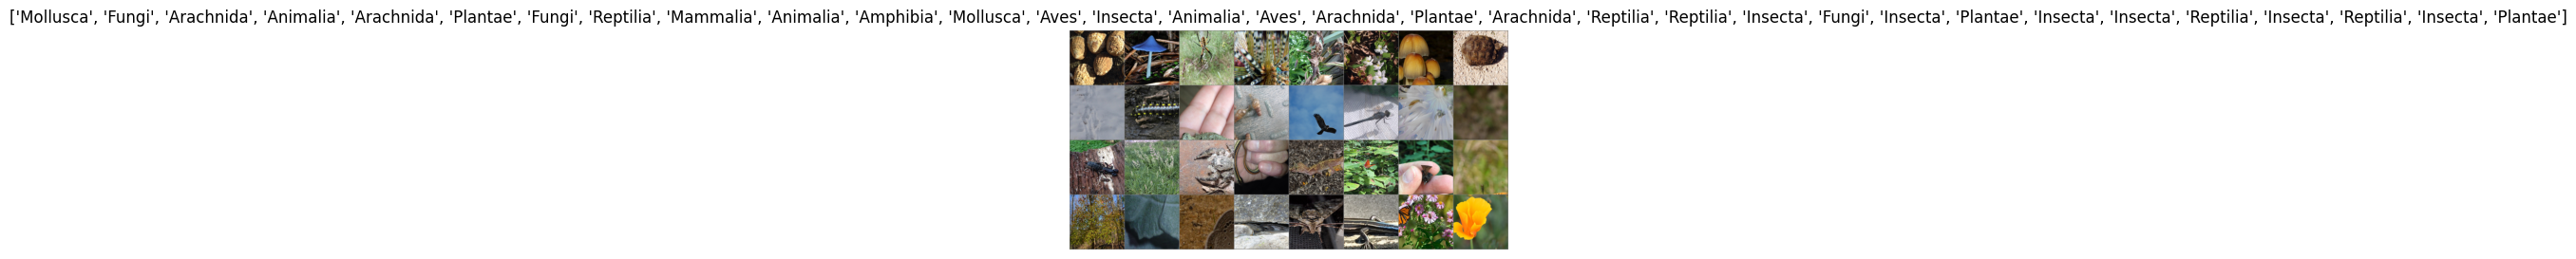

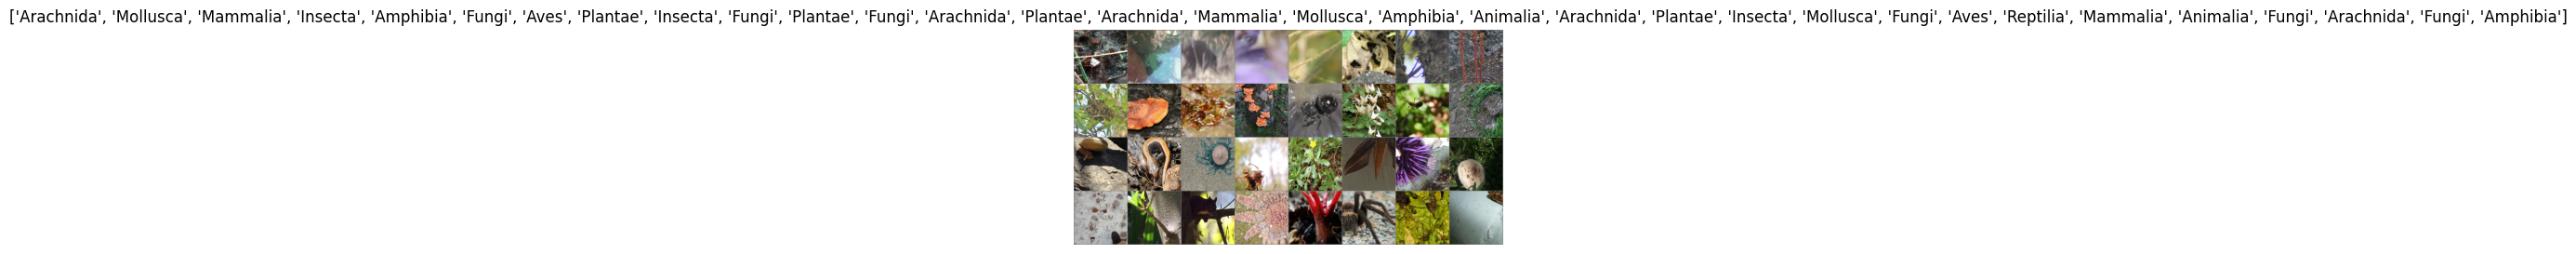

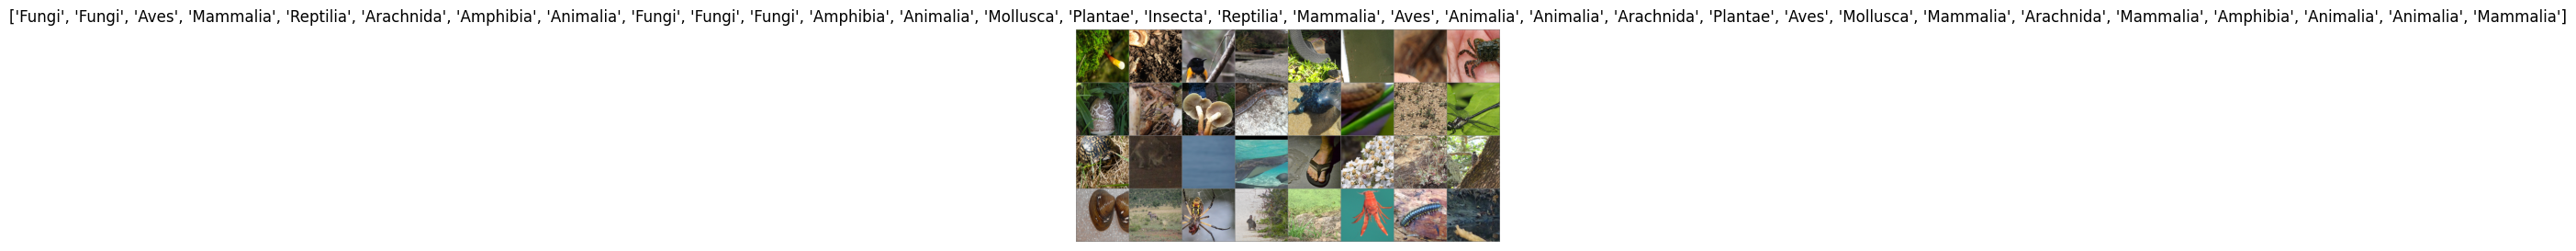

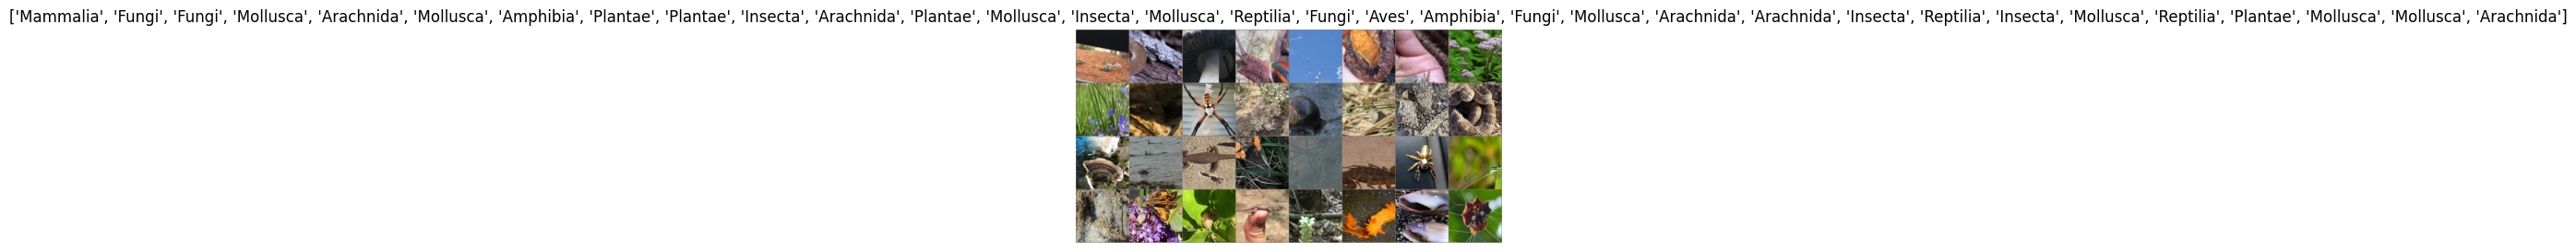

In [12]:
for i in range(4):
  show_batch_images(train_loader)

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [14]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    max_values, pred_class = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred_class == labels).sum().item()
  return 100*correct/total

In [17]:
resnet = models.resnet50(pretrained=True)
print(resnet)
print(sum(p.numel() for p in resnet.parameters()))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
for param in resnet.parameters():
  param.requires_grad = False

In [24]:
final_in_features = resnet.fc.in_features
resnet.fc= nn.Linear(final_in_features, num_classes)

In [25]:
resnet = resnet.to(device)

In [26]:
next(resnet.parameters()).is_cuda

True

In [27]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 2048])
torch.Size([10])


In [28]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=config['learning_rate'])

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Min Loss: 2.33
Iteration: 0/250, Loss: 2.33
Min Loss: 2.25
Min Loss: 2.04
Min Loss: 1.99
Min Loss: 1.84
Min Loss: 1.76
Min Loss: 1.60
Min Loss: 1.59
Min Loss: 1.57
Min Loss: 1.40
Min Loss: 1.31
Min Loss: 1.28
Min Loss: 1.25
Min Loss: 1.20
Min Loss: 1.08
Min Loss: 1.04
Min Loss: 1.03
Min Loss: 0.90
Min Loss: 0.86
Min Loss: 0.80
Iteration: 100/250, Loss: 0.98
Min Loss: 0.59
Min Loss: 0.56
Iteration: 200/250, Loss: 0.77
Min Loss: 0.56
Min Loss: 0.47
Epoch: 0/10, Loss: 1.02, Validation accuracy: 69.98, Train accuracy: 71.69
Iteration: 0/250, Loss: 1.04
Min Loss: 0.44
Iteration: 100/250, Loss: 0.92
Iteration: 200/250, Loss: 0.63
Min Loss: 0.31
Epoch: 1/10, Loss: 0.76, Validation accuracy: 73.09, Train accuracy: 73.47
Iteration: 0/250, Loss: 1.15
Min Loss: 0.29
Iteration: 100/250, Loss: 1.06
Iteration: 200/250, Loss: 0.93
Epoch: 2/10, Loss: 0.63, Validation accuracy: 74.39, Train accuracy: 75.29
Iteration: 0/250, Loss: 0.46
Iteration: 100/250, Loss: 0.59
Iteration: 200/250, Loss: 0.79
Epoch:

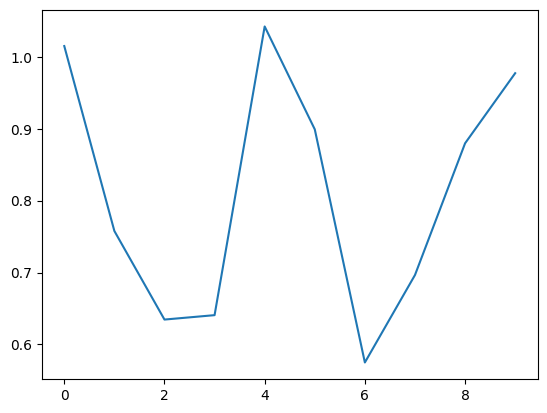

CPU times: user 1h 9min 6s, sys: 37.4 s, total: 1h 9min 43s
Wall time: 1h 10min 7s


In [29]:
%%time
loss_arr = []
loss_ep_arr = []
max_epochs = 10

min_loss = 1000
n_iters = np.ceil(8000/batch_size)

for epoch in range(max_epochs):
  torch.cuda.empty_cache()
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()
    outputs = resnet(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(resnet.state_dict())
      print('Min Loss: %0.2f'%min_loss)

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f'%(i, n_iters, loss.item()))

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    loss_arr.append(loss.item())
  loss_ep_arr.append(loss.item())
  print('Epoch: %d/%d, Loss: %0.2f, Validation accuracy: %0.2f, Train accuracy: %0.2f'%((epoch+1), max_epochs, loss.item(), evaluation(val_loader, resnet), evaluation(train_loader, resnet)))
  # Epoch: 0/1, Loss: 0.84, Validation accuracy: 71.04, Train accuracy: 72.45
plt.plot(loss_ep_arr)
plt.show()